In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob

In [2]:
imgs_path = glob.glob("../input/birds-200/birds_train/*/*.jpg")

In [3]:
imgs_path[:3]

['../input/birds-200/birds_train/037.Acadian_Flycatcher/20.jpg',
 '../input/birds-200/birds_train/037.Acadian_Flycatcher/6.jpg',
 '../input/birds-200/birds_train/037.Acadian_Flycatcher/5.jpg']

In [4]:
img_p = imgs_path[1000]
img_p

'../input/birds-200/birds_train/128.Seaside_Sparrow/20.jpg'

In [5]:
img_p.split("/")[4].split('.')[1]

'Seaside_Sparrow'

In [6]:
all_label_name = [img_p.split("/")[4].split('.')[1] for img_p in imgs_path]

In [7]:
all_label_name[:3]

['Acadian_Flycatcher', 'Acadian_Flycatcher', 'Acadian_Flycatcher']

In [8]:
all_label_name[-3:]

['Pileated_Woodpecker', 'Pileated_Woodpecker', 'Pileated_Woodpecker']

In [9]:
label_names = np.unique(all_label_name)

In [10]:
len(label_names)

200

In [11]:
label_to_index = dict((name,i) for i,name in enumerate(label_names))

In [12]:
index_to_label = dict((v,k) for k,v in label_to_index.items())

In [13]:
all_labels =[label_to_index.get(name) for name in all_label_name]

In [14]:
all_labels[:3]

[0, 0, 0]

In [15]:
np.random.seed(2021)
random_index = np.random.permutation(len(imgs_path))

In [16]:
imgs_path = np.array(imgs_path)[random_index]
all_labels = np.array(all_labels)[random_index]

In [17]:
i = int(len(imgs_path)*0.8)

In [18]:
train_path = imgs_path[:i]
train_label = all_labels[:i]
test_path = imgs_path[i:]
test_label = all_labels[i:]

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path,train_label))
test_ds = tf.data.Dataset.from_tensor_slices((test_path,test_label))

In [20]:
def load_img(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image,tf.float32)
    image = image/255
    return image,label

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(load_img,num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_img,num_parallel_calls=AUTOTUNE)

In [22]:
train_ds

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int64)>

In [23]:
BATCH_SIZE = 32

In [24]:
train_ds = train_ds.repeat().shuffle(300).batch(BATCH_SIZE)

In [25]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>

In [26]:
test_ds = test_ds.batch(BATCH_SIZE)

In [27]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),                                                         activation='relu'))
#64卷积核，3*3大小
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(1024,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(200))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 128)     5

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [30]:
train_count = len(train_path)
test_count = len(test_path)

In [31]:
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = test_count//BATCH_SIZE

In [32]:
history = model.fit(
    train_ds,epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=validation_steps)

Epoch 1/10
200/200 [==============================] - 99s 458ms/step - loss: 5.5578 - acc: 0.0205 - val_loss: 6.3020 - val_acc: 0.0025
Epoch 2/10
200/200 [==============================] - 65s 327ms/step - loss: 4.8428 - acc: 0.0393 - val_loss: 6.4313 - val_acc: 0.0063
Epoch 3/10
200/200 [==============================] - 65s 327ms/step - loss: 4.5200 - acc: 0.0628 - val_loss: 5.0546 - val_acc: 0.0237
Epoch 4/10
200/200 [==============================] - 65s 325ms/step - loss: 4.2768 - acc: 0.0784 - val_loss: 4.5336 - val_acc: 0.0681
Epoch 5/10
200/200 [==============================] - 65s 323ms/step - loss: 4.0802 - acc: 0.1040 - val_loss: 4.5367 - val_acc: 0.0769
Epoch 6/10
200/200 [==============================] - 65s 326ms/step - loss: 3.8390 - acc: 0.1406 - val_loss: 4.5110 - val_acc: 0.0844
Epoch 7/10
200/200 [==============================] - 65s 325ms/step - loss: 3.6772 - acc: 0.1577 - val_loss: 4.1850 - val_acc: 0.1119
Epoch 8/10
200/200 [==============================] - 6

In [33]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

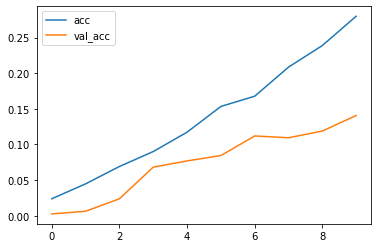

In [34]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')
plt.legend()

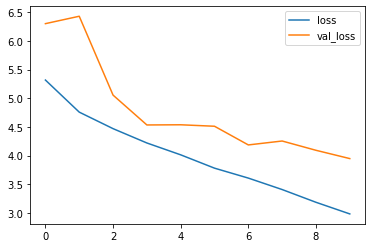

In [35]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')
plt.legend()

In [36]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image,tf.float32)
    image = image/255
    return image

In [37]:
test_img = '../input/birds-200/birds_train/002.Laysan_Albatross/0.jpg'
test_tensor = load_and_preprocess_image(test_img)
test_tensor = tf.expand_dims(test_tensor,axis=0)
pred = model.predict(test_tensor)

In [38]:
index_to_label.get(np.argmax(pred))

'Long_tailed_Jaeger'